In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings("ignore")

In [20]:
with open('team_name_correction.json', 'r') as f:
    team_name_correction = json.load(f)

with open('stadium_name_correction.json', 'r') as f:
    stadium_name_correction = json.load(f)    

df=pd.read_csv("matches.csv")
df=df.replace(team_name_correction)
df=df.replace(stadium_name_correction)

#### Toss winner vs Old Winner

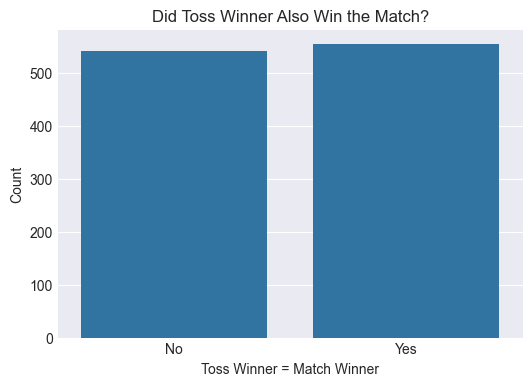

In [21]:
df["toss_win_match_win"] = df["toss_winner"] == df["winner"]

plt.figure(figsize=(6, 4))
sns.countplot(x="toss_win_match_win", data=df)
plt.title("Did Toss Winner Also Win the Match?")
plt.xlabel("Toss Winner = Match Winner")
plt.ylabel("Count")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()


#### Distribution of Victory Margins (Runs)

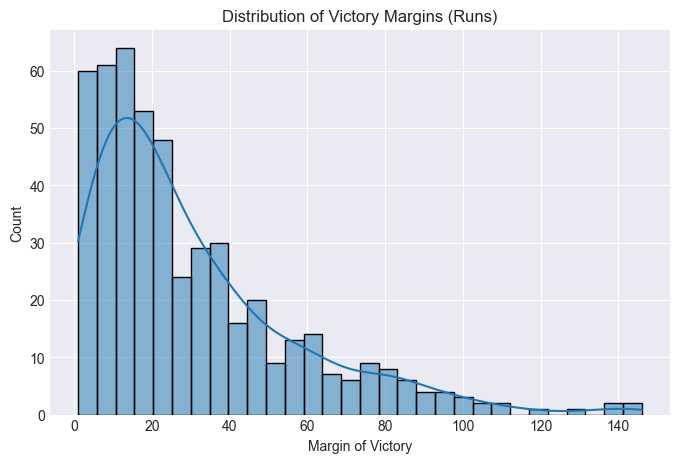

In [22]:
plt.figure(figsize=(8, 5))
sns.histplot(df[df["result"]=="runs"]["result_margin"], bins=30, kde=True)
plt.title("Distribution of Victory Margins (Runs)")
plt.xlabel("Margin of Victory")
plt.show()


#### Distribution of Victory (wickets)

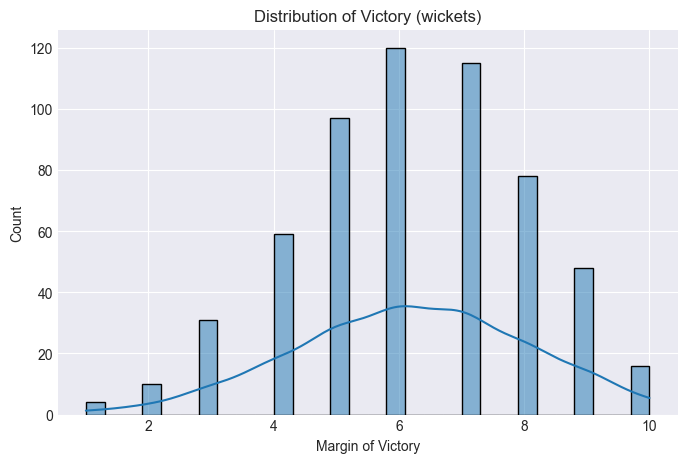

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(df[df["result"]=="wickets"]["result_margin"], bins=30, kde=True)
plt.title("Distribution of Victory (wickets)")
plt.xlabel("Margin of Victory")
plt.show()


#### Venues with most win when batting first and venues with most win when bowling first

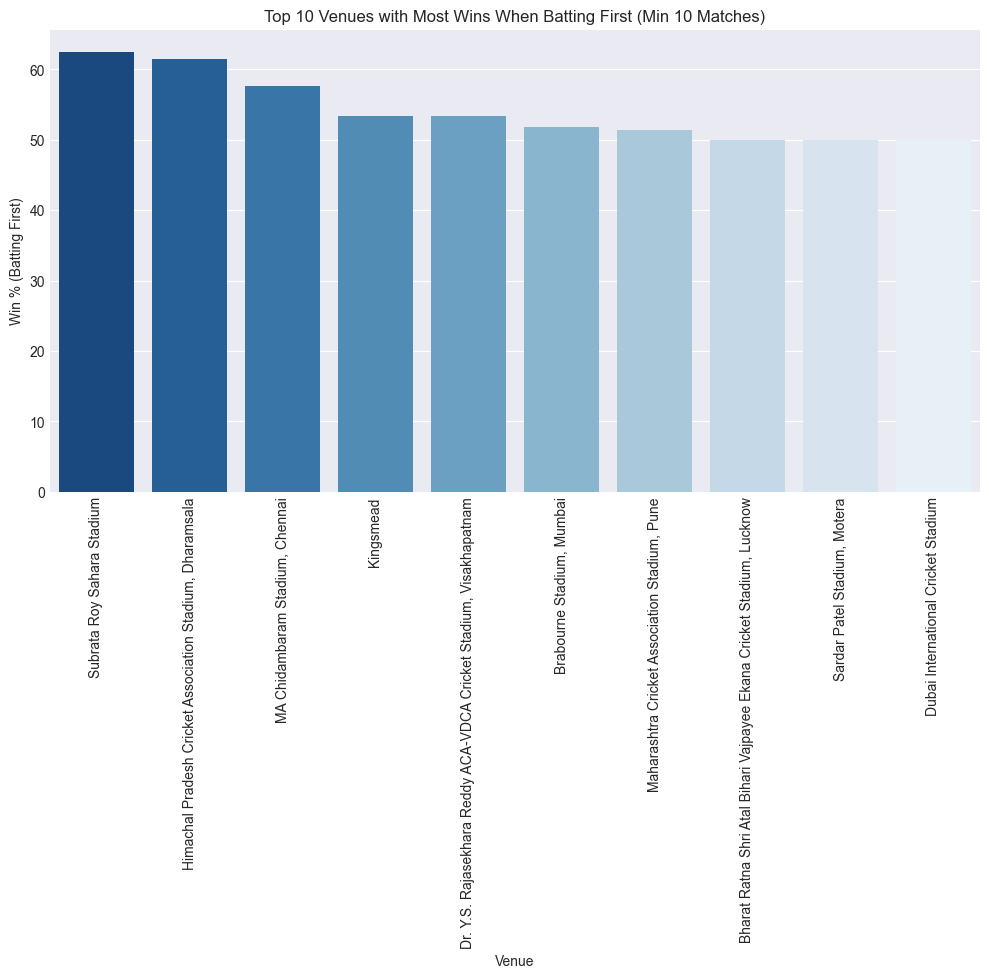

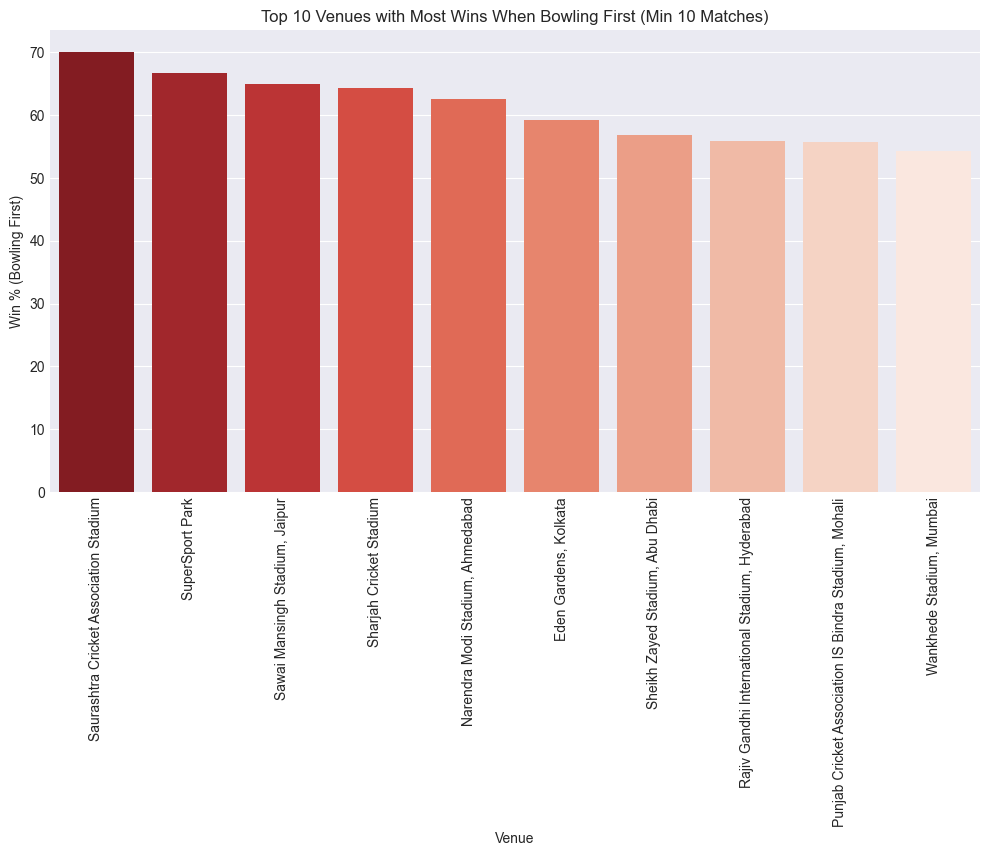

In [24]:
df["winner_batted_first"] = (
    ((df["winner"] == df["toss_winner"]) & (df["toss_decision"] == "bat")) | 
    ((df["winner"] != df["toss_winner"]) & (df["toss_decision"] == "field"))
)

df["winner_bowled_first"] = ~df["winner_batted_first"] 


venue_total_matches = df["venue"].value_counts()


valid_venues = venue_total_matches[venue_total_matches >= 10].index

venue_bat_first_wins = df[df["winner_batted_first"] & df["venue"].isin(valid_venues)].groupby("venue")["winner"].count()
venue_bowl_first_wins = df[df["winner_bowled_first"] & df["venue"].isin(valid_venues)].groupby("venue")["winner"].count()

venue_bat_first_win_pct = (venue_bat_first_wins / venue_total_matches * 100).dropna().sort_values(ascending=False)
venue_bowl_first_win_pct = (venue_bowl_first_wins / venue_total_matches * 100).dropna().sort_values(ascending=False)

df["bat_first_win_pct"] = df["venue"].map(venue_bat_first_win_pct).fillna(0)
df["bowl_first_win_pct"] = df["venue"].map(venue_bowl_first_win_pct).fillna(0)


plt.figure(figsize=(12, 6))
sns.barplot(x=venue_bat_first_win_pct.index[:10], y=venue_bat_first_win_pct.values[:10], palette="Blues_r")
plt.xticks(rotation=90)
plt.title("Top 10 Venues with Most Wins When Batting First (Min 10 Matches)")
plt.xlabel("Venue")
plt.ylabel("Win % (Batting First)")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=venue_bowl_first_win_pct.index[:10], y=venue_bowl_first_win_pct.values[:10], palette="Reds_r")
plt.xticks(rotation=90)
plt.title("Top 10 Venues with Most Wins When Bowling First (Min 10 Matches)")
plt.xlabel("Venue")
plt.ylabel("Win % (Bowling First)")
plt.show()

#### Top 10 Players with Most Player of the Match 

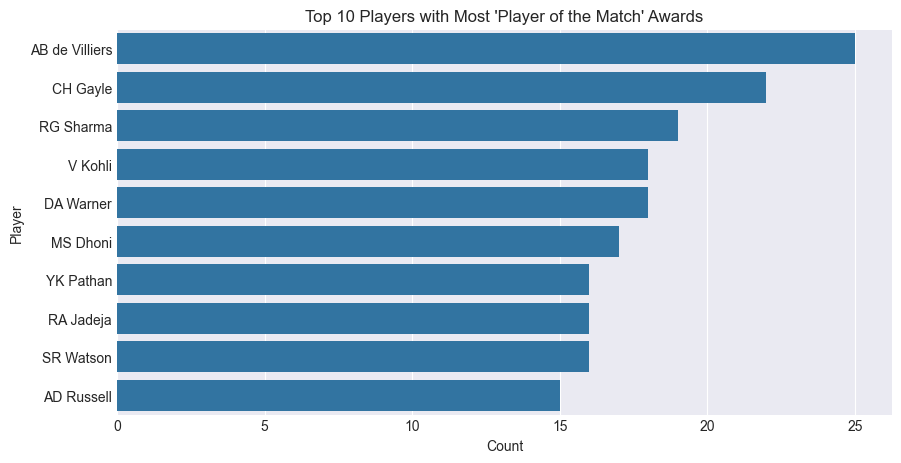

In [25]:
top_players = df["player_of_match"].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(y=top_players.index, x=top_players.values)
plt.title("Top 10 Players with Most 'Player of the Match' Awards")
plt.xlabel("Count")
plt.ylabel("Player")
plt.show()


#### Impact of Toss win 

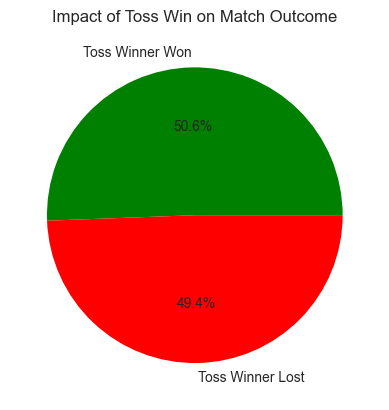

In [26]:
toss_win = df[df["toss_winner"] == df["winner"]].shape[0]
toss_loss = df[df["toss_winner"] != df["winner"]].shape[0]

plt.pie([toss_win, toss_loss], labels=["Toss Winner Won", "Toss Winner Lost"], autopct="%1.1f%%", colors=["green", "red"])
plt.title("Impact of Toss Win on Match Outcome")
plt.show()


#### Venues with Most Super Overs

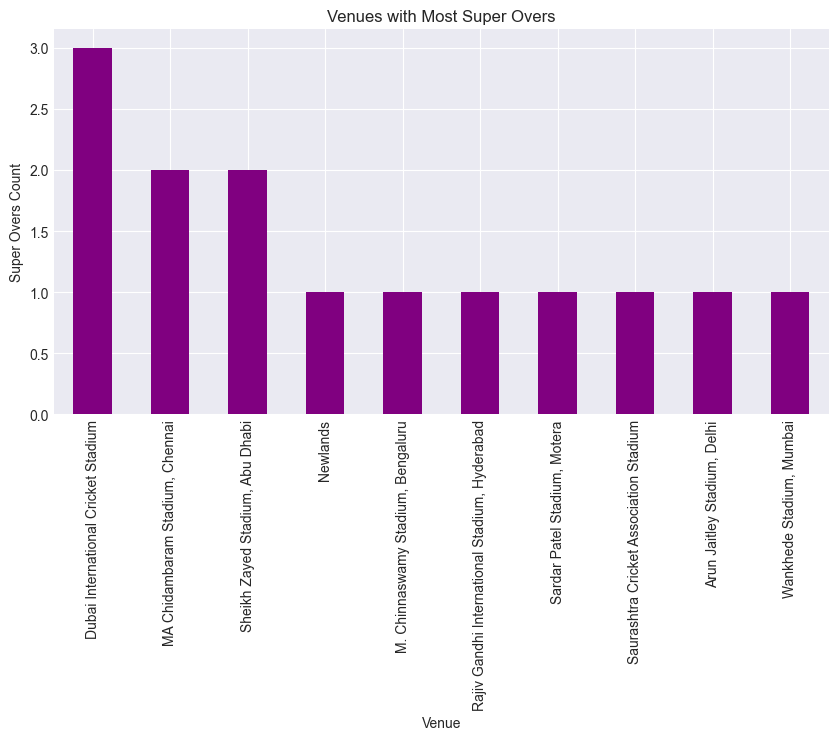

In [27]:
super_over_venues = df[df["super_over"] == "Y"]["venue"].value_counts()
super_over_venues[:10].plot(kind="bar", figsize=(10, 5), color="purple")
plt.title("Venues with Most Super Overs")
plt.xlabel("Venue")
plt.ylabel("Super Overs Count")
plt.xticks(rotation=90)
plt.show()


#### Top 10 Teams by wins while chasing vs defending

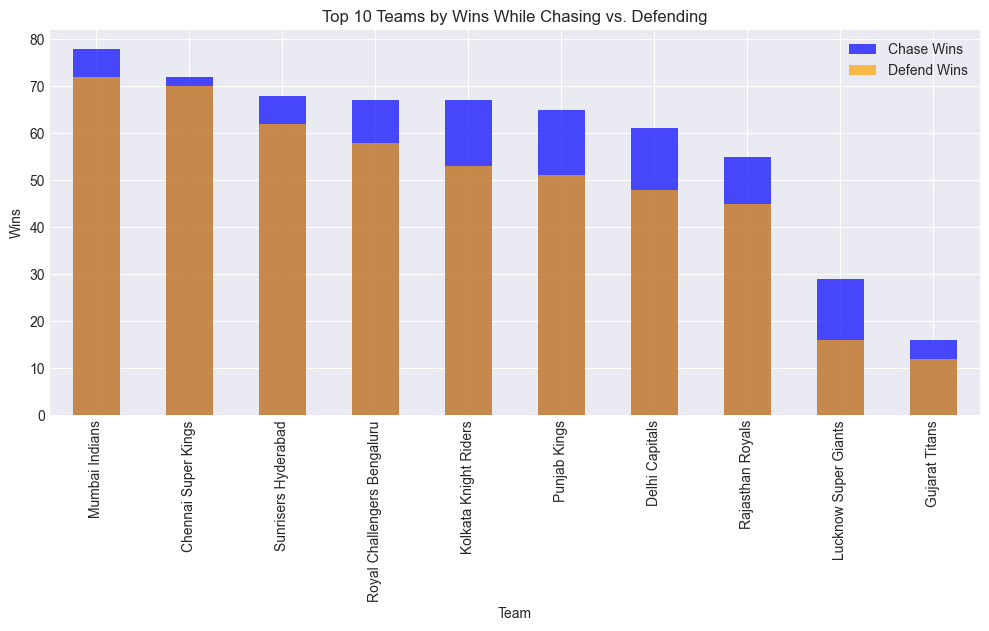

In [28]:
df["won_batting_first"] = ((df["winner"] == df["toss_winner"]) & (df["toss_decision"] == "bat")) | \
                          ((df["winner"] != df["toss_winner"]) & (df["toss_decision"] == "field"))

team_chase_wins = df[~df["won_batting_first"]].groupby("winner")["winner"].count()
team_defend_wins = df[df["won_batting_first"]].groupby("winner")["winner"].count()


plt.figure(figsize=(12, 5))
team_chase_wins.sort_values(ascending=False)[:10].plot(kind="bar", color="blue", alpha=0.7, label="Chase Wins")
team_defend_wins.sort_values(ascending=False)[:10].plot(kind="bar", color="orange", alpha=0.7, label="Defend Wins")
plt.title("Top 10 Teams by Wins While Chasing vs. Defending")
plt.xlabel("Team")
plt.ylabel("Wins")
plt.legend()
plt.xticks(rotation=90)
plt.show()


#### Toss Decision & Winning Probability

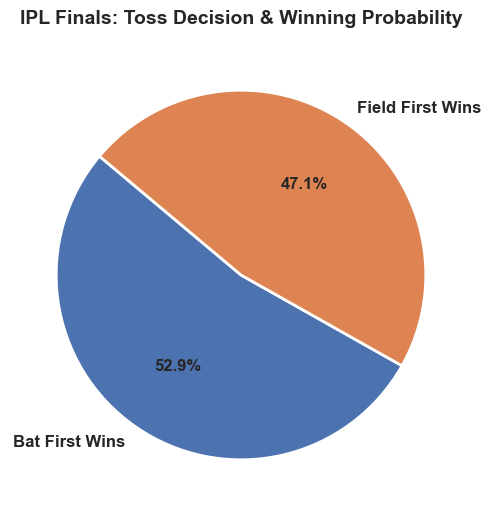

In [29]:
plt.style.use("seaborn-v0_8-darkgrid")
finals = df[df["match_type"] == "Final"]
bat_first_wins = ((finals["toss_decision"] == "bat") & (finals["toss_winner"] == finals["winner"])).sum() + \
                 ((finals["toss_decision"] == "field") & (finals["toss_winner"] != finals["winner"])).sum()

field_first_wins = ((finals["toss_decision"] == "field") & (finals["toss_winner"] == finals["winner"])).sum() + \
                   ((finals["toss_decision"] == "bat") & (finals["toss_winner"] != finals["winner"])).sum()
colors = ["#4c72b0", "#dd8452"]  
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    [bat_first_wins, field_first_wins],
    labels=["Bat First Wins", "Field First Wins"],
    autopct="%1.1f%%",
    colors=colors,
    startangle=140,
    wedgeprops={"edgecolor": "white", "linewidth": 2, "antialiased": True},
    textprops={"fontsize": 12, "weight": "bold"}
)
plt.title("IPL Finals: Toss Decision & Winning Probability", fontsize=14, fontweight="bold", pad=15)

plt.show()


#### Top 10 IPL venues by Match Hosted

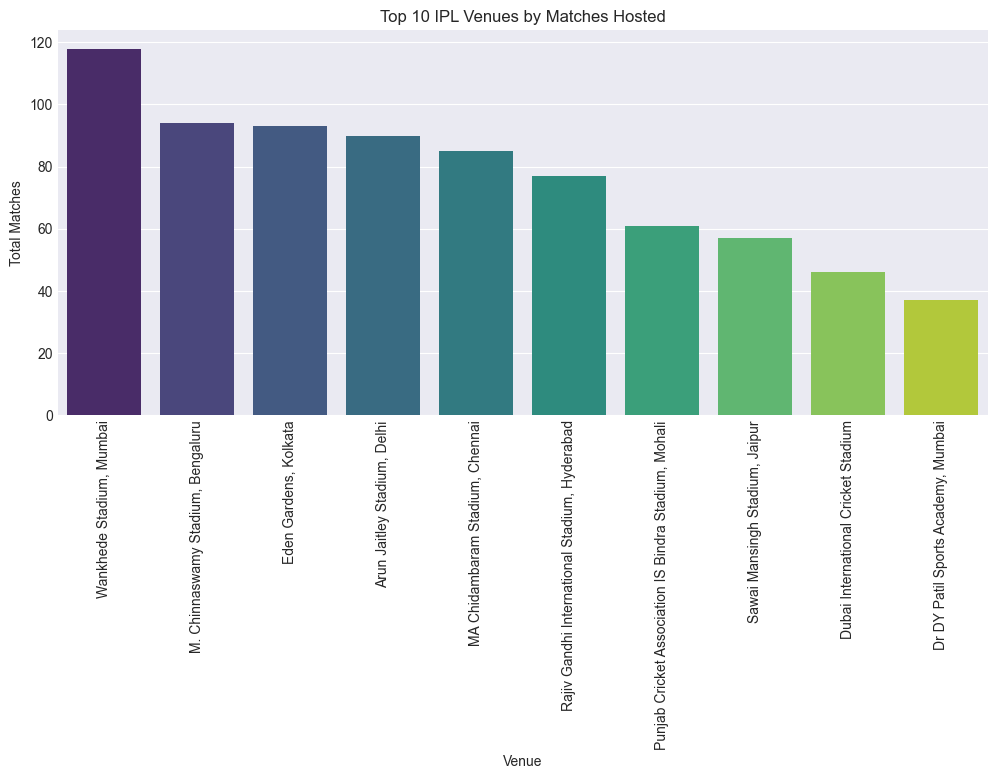

In [30]:
venue_counts = df["venue"].value_counts()
plt.figure(figsize=(12, 5))
sns.barplot(x=venue_counts.index[:10], y=venue_counts.values[:10], palette="viridis")
plt.xticks(rotation=90)
plt.title("Top 10 IPL Venues by Matches Hosted")
plt.xlabel("Venue")
plt.ylabel("Total Matches")
plt.show()


#### Average Run chase per season

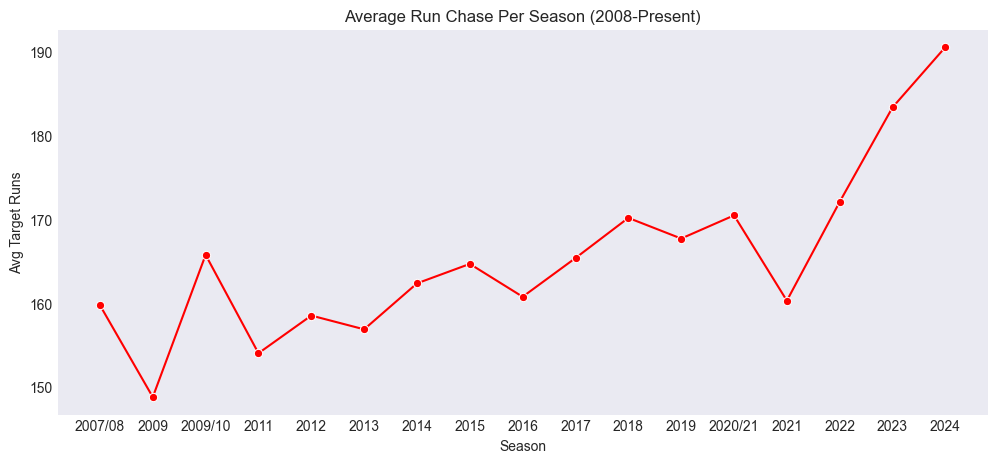

In [31]:

avg_target_runs = df.groupby("season")["target_runs"].mean()

plt.figure(figsize=(12, 5))
sns.lineplot(x=avg_target_runs.index, y=avg_target_runs.values, marker="o", color="red")
plt.title("Average Run Chase Per Season (2008-Present)")
plt.xlabel("Season")
plt.ylabel("Avg Target Runs")
plt.grid()
plt.show()


#### Effect of rain on wins: Bat first vs field first

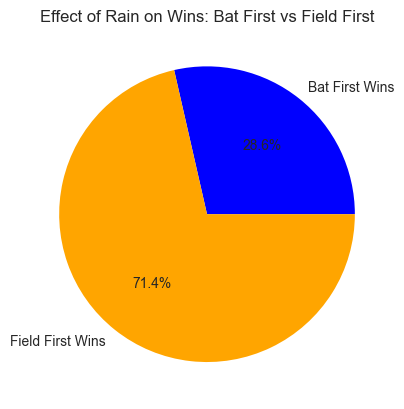

In [32]:

rain_affected = df[df["method"].notna()]


bat_first_rain_wins = rain_affected[(rain_affected["toss_decision"] == "bat") & (rain_affected["toss_winner"] == rain_affected["winner"])].shape[0] + \
                       rain_affected[(rain_affected["toss_decision"] == "field") & (rain_affected["toss_winner"] != rain_affected["winner"])].shape[0]

field_first_rain_wins = rain_affected[(rain_affected["toss_decision"] == "field") & (rain_affected["toss_winner"] == rain_affected["winner"])].shape[0] + \
                         rain_affected[(rain_affected["toss_decision"] == "bat") & (rain_affected["toss_winner"] != rain_affected["winner"])].shape[0]


plt.pie([bat_first_rain_wins, field_first_rain_wins], labels=["Bat First Wins", "Field First Wins"], autopct="%1.1f%%", colors=["blue", "orange"])
plt.title("Effect of Rain on Wins: Bat First vs Field First")
plt.show()